# Homework 5 - Sparsity (PCA and Compressive Sensing)
## Name: Sondre Kongsgaard
## Collaboration group: Anders Vagle, Brage Saether, Morten Lie

# 0)  Data Generation

## 0.1) Generate a vectur *u* in $d$ dimensions

In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt

d = 100

def generate_random_vector(d):
    u = np.zeros((d, 1)) 
    P_1 = 2.0/3
    P_2 = 1.0/6
    for i in range(d):
        a = random.uniform(0, 1)
        if (a < P_1):
            u[i] = 0
        elif (a < P_1 + P_2):
            u[i] = 1
        else:
            u[i] = -1
    return u

u = np.zeros((d, 6))
for j in range(6):
    u[:, j] = generate_random_vector(d).T
    for t in range(j):
        #print('Old= {:}'.format(abs(u[:, t:t+1].T @ u[:, j:j+1])))
        while abs(u[:, t:t+1].T @ u[:, j:j+1]) > d/12:
            u[:, j] = generate_random_vector(d).T
            #print(abs(u[:, t:t+1].T @ u[:, j:j+1]))
#print(u)

## 0.2) Generate $d$-dimensional  data samples for a Gaussian mixture distribution with 3 equiprobable components

In [2]:
def generate_d_dimensional_gaussian_components(N, d, u):
    pi_1 = 1.0 / 3
    pi_2 = 1.0 / 3

    sigma_squared = 0.01

    x = np.zeros((N, d))
    z = np.zeros((N, 3)) # One-hot encoding
    for i in range(N):
        Z_1 = np.random.normal(0, 1, 1)
        Z_2 = np.random.normal(0, 1, 1)
        noise = np.random.multivariate_normal(np.zeros(d), sigma_squared*np.eye(d), 1)

        a = random.uniform(0, 1)
        if (a < pi_1):
            x[i, :] = u[:, 0] + Z_1*u[:, 1] + Z_2*u[:, 2] + noise
            z[i][0] = 1
        elif (a < pi_1 + pi_2):
            x[i, :] = 2*u[:, 3] + math.sqrt(2)*Z_1*u[:, 4] + Z_2*u[:, 5] + noise
            z[i][1] = 1
        else:
            x[i, :] = math.sqrt(2)*u[:, 5] + Z_1*(u[:, 0] + u[:, 1]) + 1.0/math.sqrt(2)*Z_2*u[:,4] + noise
            z[i][2] = 1
    return x, z

N = 200
x_orig, z_orig = generate_d_dimensional_gaussian_components(N, d, u)

# Part I: PCA

## 1a)

In [3]:
_, s, _ = np.linalg.svd(x_orig, full_matrices=True)

In [4]:
# Singular values:
print(s)

[104.7344648   89.38199688  75.00956726  53.75595448  49.51088431
  40.65488671   2.31601319   2.2703376    2.21131389   2.17421537
   2.15233782   2.11805608   2.09848354   2.07948945   2.02455934
   1.99947618   1.97184518   1.94444776   1.93812383   1.93438712
   1.89059303   1.85448352   1.82257614   1.81812055   1.80700865
   1.77878898   1.76459153   1.73165681   1.70363637   1.68071207
   1.66587952   1.65140108   1.62223313   1.61626669   1.60139223
   1.57672393   1.57343057   1.5567698    1.55028464   1.49795814
   1.48418971   1.47226781   1.43672011   1.43027481   1.41528574
   1.40130143   1.37940296   1.36072505   1.34436456   1.3273235
   1.3111523    1.30046653   1.27327699   1.24925627   1.24612923
   1.2211872    1.20180926   1.18268642   1.18123076   1.15588082
   1.14388694   1.12999457   1.11241425   1.08023749   1.0743628
   1.05834129   1.04745438   1.03416254   1.02784374   0.9777091
   0.9752035    0.95192909   0.93640519   0.9197308    0.90824051
   0.89317965

We see $d_0=6$ dominant singular values with N=2d=200 (there is a big difference between the 6th and 7th singular value, comparatively, and the vector is sorted in decreasing order).
With N=2d=400 or N=4d=800 (or N=d=100), we still get the same number of singular values, $d_0=6$.

In [5]:
d_0 = len(s[0:6])

## 1b)

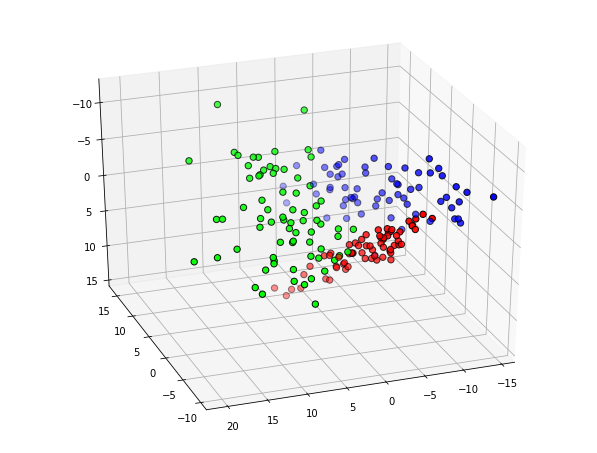

In [6]:
from sklearn.decomposition import PCA
x_reduced = PCA(n_components=d_0).fit_transform(x_orig)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(x_reduced[:, 0], x_reduced[:, 1], x_reduced[:, 2],
           c=z_orig, cmap=plt.cm.Set1, edgecolor='k', s=40)

In [7]:
def k_means(N, K, C, x):
    m = np.zeros((K, np.size(x, 1)))
    C_new = np.zeros((N, 1))
    while True:
        for j in range(K):
            C_abs = 0
            for i in range(N):
                if C[i] == j+1:
                    C_abs += 1
                    m[j] += x[i]
            if C_abs == 0:
                C_abs = 1
            m[j] /= C_abs
        
        for i in range(N):
            min_distance = math.inf
            for j in range(K):
                distance = np.linalg.norm(x[i] - m[j])
                if distance < min_distance:
                    C_new[i] = j+1
                    min_distance = distance
        
        # Check for convergence
        if np.all(C_new == C):
            return m, C_new
        
        C = C_new
        
def mean_squared_error(x, m, C):
    N = len(x)
    K = len(m)
    smse = np.zeros((K,1))
    for i in range(N):
        j = int(C[i])
        smse[j-1] += np.linalg.norm(x[i] - m[j-1])
    return np.sum(smse) / N

In [8]:
n_random_initializations = 5
K_max = 5

m_optimal = np.zeros((K_max, np.size(x_reduced, 1), K_max))
C_optimal = np.zeros((N, K_max))

for K in range(2, K_max+1):
    min_mse = math.inf
    for i in range(n_random_initializations):
        C = np.random.randint(1, high=K+1, size=(N, 1))
        m, C = k_means(N, K, C, x_reduced)
        mse = mean_squared_error(x_reduced, m, C)
        if mse < min_mse:
            m_optimal[0:K, :, K-1] = m
            C_optimal[:, K-1] = C.T
            min_mse = mse
print("K-means complete")

# Compute one-hot encoding 
a = np.zeros((N, K_max, K_max))
for K in range(1, K_max):
    for i in range(N):
        a[i, int(C_optimal[i, K])-1, K] = 1

K-means complete


In [9]:
def empirical_probabilities(z, a):
    empirical_probabilities = np.zeros((3, K_max, K_max))
    for K in range(2, K_max+1):
        for li in range(3):
            for j in range(K):
                num_a = 0
                num_z = 0
                for i in range(N):
                    if z[i, li] == 1:
                        num_z += 1
                        if a[i, j, K-1] == 1:
                            num_a += 1
                empirical_probabilities[li, j, K-1] = num_a / num_z
    return empirical_probabilities

print(empirical_probabilities(z_orig, a))

[[[0.         0.04615385 0.72307692 0.         0.        ]
  [0.         0.95384615 0.         0.         0.47692308]
  [0.         0.         0.27692308 0.16923077 0.        ]
  [0.         0.         0.         0.83076923 0.52307692]
  [0.         0.         0.         0.         0.        ]]

 [[0.         1.         0.         0.         0.41666667]
  [0.         0.         0.93055556 0.34722222 0.        ]
  [0.         0.         0.06944444 0.65277778 0.56944444]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.01388889]]

 [[0.         0.         0.53968254 0.55555556 0.        ]
  [0.         1.         0.         0.         0.        ]
  [0.         0.         0.46031746 0.         0.        ]
  [0.         0.         0.         0.44444444 0.15873016]
  [0.         0.         0.         0.         0.84126984]]]


Read the table above as for each _true_ class (e.g. 3), if K is e.g. 2, the conditional probabilities for each assigned class are printed in the second column in the third 2D table.

## 2) Geometric insight into how the cluster centers found by $K$-means relate to the $d_0$-dimensional projections of the vectors $\{\mathbf{u}_j\}$ in the model

In [10]:
#print(C_optimal)

print(m_optimal.shape)
print(u.shape)

corr = np.zeros((K_max-1, 5, 6))
#for K in range(2, K_max+1):
#    corr[K-2] = m_optimal[K-1, :, :].T @ u

print(corr)

#for j in range(6):
#    for t in range(j):

(5, 6, 5)
(100, 6)
[[[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]]


# Part II: Random Projections and Compressed Sensing
## 3)

In [11]:
def generate_Phi(m, d):
    Phi = np.random.randint(0, 2, size=(m, d))
    Phi = 2.0*Phi - 1.0
    return Phi

def generate_d_dimensional_gaussian_components_and_keep_s(N, d, u):    
    pi_1 = 1.0 / 3
    pi_2 = 1.0 / 3

    sigma_squared = 0.01

    x = np.zeros((N, d))
    s = np.zeros((N, d))
    z = np.zeros((N, 3)) # One-hot encoding
    for i in range(N):
        Z_1 = np.random.normal(0, 1, 1)
        Z_2 = np.random.normal(0, 1, 1)
        noise = np.random.multivariate_normal(np.zeros(d), sigma_squared*np.eye(d), 1)

        a = random.uniform(0, 1)
        if (a < pi_1):
            s[i, :] = u[:, 0] + Z_1*u[:, 1] + Z_2*u[:, 2]
            x[i, :] = s[i, :] + noise
            z[i][0] = 1
        elif (a < pi_1 + pi_2):
            s[i, :] = 2*u[:, 3] + math.sqrt(2)*Z_1*u[:, 4] + Z_2*u[:, 5]
            x[i, :] = s[i, :] + noise
            z[i][1] = 1
        else:
            s[i, :] = math.sqrt(2)*u[:, 5] + Z_1*(u[:, 0] + u[:, 1]) + 1.0/math.sqrt(2)*Z_2*u[:,4]
            x[i, :] = s[i, :] + noise
            z[i][2] = 1
    return s, x, z

N = 200
m = 10
Phi = generate_Phi(m, d)
s, x, z = generate_d_dimensional_gaussian_components_and_keep_s(N, d, u)

# Compute the compressive projection
import math
y = 1. / math.sqrt(m) * Phi @ x.T

# Define basis for the signal
B = u # B = [u_1, u_2, u_3, u_4, u_5, u_6]

## 4)

In [12]:
from sklearn.linear_model import Lasso
rgr_lasso = Lasso(alpha=0.05, max_iter=10000)
rgr_lasso.fit(1. / math.sqrt(m) * Phi @ B, y)
a_hat = rgr_lasso.coef_

s_hat = (B @ a_hat.T).T

In [13]:
from sklearn.linear_model import Lasso
def sparse_reconstruction_with_lasso(m, Phi, B, y, alpha=0.05):
    rgr_lasso = Lasso(alpha, max_iter=10000)
    rgr_lasso.fit(1. / math.sqrt(m) * Phi @ B, y)
    a_hat = rgr_lasso.coef_
    s_hat = (B @ a_hat.T).T
    return a_hat, s_hat

## 5)

MSE_normalized_average: 0.0002923065371928979


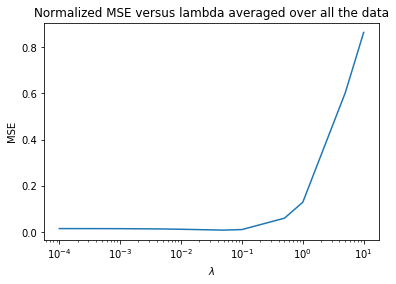

In [14]:
def MSE_normalized(s_hat, s):
    return (np.linalg.norm(s_hat - s))**2 / (np.linalg.norm(s))**2

# Compute the normalized MSE averaging over many draws, with lambda/alpha = 0.05
MSE_normalized_sum = 0
for i in range(3): # TODO: Increase
    s, x, _ = generate_d_dimensional_gaussian_components_and_keep_s(N, d, u)
    y = 1. / math.sqrt(m) * Phi @ x.T
    _, s_hat = sparse_reconstruction_with_lasso(m, Phi, B, y)
    MSE_normalized_sum += MSE_normalized(s_hat, s)
MSE_normalized_average = MSE_normalized_sum / 100.
print("MSE_normalized_average: {}".format(MSE_normalized_average))

# Plot the normalized MSE versus lambda/alpha
lambdas = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
MSE_normalized_for_several_lambdas = []
for l in lambdas:
    _, s_hat = sparse_reconstruction_with_lasso(m, Phi, B, y, alpha=l)
    MSE_normalized_for_several_lambdas.append(MSE_normalized(s_hat, s))
plt.semilogx(lambdas, MSE_normalized_for_several_lambdas)
plt.title("Normalized MSE versus lambda averaged over all the data")
plt.xlabel("$\lambda$")
plt.ylabel("MSE")
plt.show()

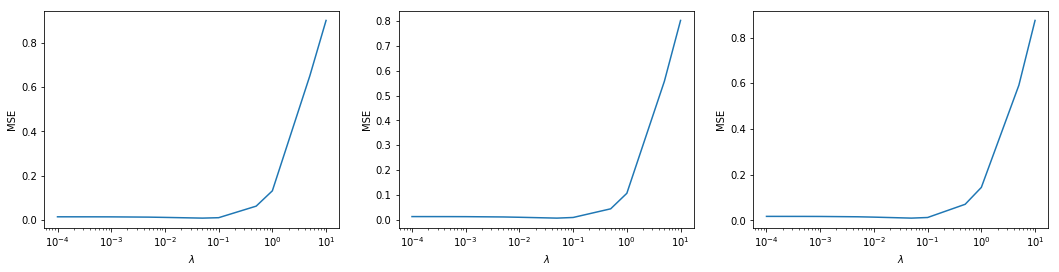

In [15]:
# Plot the normalized MSE versus λ averaging over data drawn from each of the three mixture components
lambdas = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
MSE_normalized_for_several_lambdas = np.zeros((len(lambdas), 3))
plt.figure(figsize=(18,4))
plt.title("Normalized MSE versus λ averaging over data drawn from each of the three mixture components")
for c in range(3):
    x_component = x[z[:, c] == 1]
    s_component = s[z[:, c] == 1]
    for l in lambdas:
        y = 1. / math.sqrt(m) * Phi @ x_component.T
        _, s_hat = sparse_reconstruction_with_lasso(m, Phi, B, y, alpha=l)
        MSE_normalized_for_several_lambdas[lambdas.index(l), c] = (MSE_normalized(s_hat, s_component))

    plt.subplot(1, 3, c+1)
    plt.semilogx(lambdas, MSE_normalized_for_several_lambdas[:, c])
    plt.xlabel("$\lambda$")
    plt.ylabel("MSE")

## 6)

In [25]:
m = 10 # The value found in 4)
y = 1. / math.sqrt(m) * Phi @ x_orig.T

# Euclidean distances (u_i - u_j)^2
u_orig_distances = np.zeros((u.shape[1], u.shape[1]))
for i in range(u.shape[1]):
    for j in range(i, u.shape[1]):
        u_orig_distances[i, j] = (np.linalg.norm(u[:, i] - u[:, j]))**2
        
print(u_orig_distances)

# Euclidean distance (u^_i - u^_j)^2

(10, 200)
[[ 0. 76. 74. 56. 61. 69.]
 [ 0.  0. 72. 76. 49. 67.]
 [ 0.  0.  0. 70. 55. 69.]
 [ 0.  0.  0.  0. 67. 71.]
 [ 0.  0.  0.  0.  0. 70.]
 [ 0.  0.  0.  0.  0.  0.]]


## 7)

In [28]:
n_random_initializations = 5
K_max = 5

m_optimal = np.zeros((K_max, np.size(y.T, 1), K_max))
C_optimal = np.zeros((N, K_max))

for K in range(2, K_max+1):
    min_mse = math.inf
    for i in range(n_random_initializations):
        C = np.random.randint(1, high=K+1, size=(N, 1))
        m, C = k_means(N, K, C, y.T)
        mse = mean_squared_error(y.T, m, C)
        if mse < min_mse:
            m_optimal[0:K, :, K-1] = m
            C_optimal[:, K-1] = C.T
            min_mse = mse
print("K-means complete")

# Compute one-hot encoding 
a = np.zeros((N, K_max, K_max))
for K in range(1, K_max):
    for i in range(N):
        a[i, int(C_optimal[i, K])-1, K] = 1
        
print(empirical_probabilities(z_orig, a))

K-means complete
[[[0.         0.96923077 0.         0.30769231 0.52307692]
  [0.         0.03076923 0.58461538 0.12307692 0.33846154]
  [0.         0.         0.41538462 0.         0.13846154]
  [0.         0.         0.         0.56923077 0.        ]
  [0.         0.         0.         0.         0.        ]]

 [[0.         0.02777778 0.95833333 0.02777778 0.        ]
  [0.         0.97222222 0.02777778 0.         0.01388889]
  [0.         0.         0.01388889 0.97222222 0.        ]
  [0.         0.         0.         0.         0.625     ]
  [0.         0.         0.         0.         0.36111111]]

 [[0.         1.         0.         0.98412698 0.        ]
  [0.         0.         0.95238095 0.01587302 0.65079365]
  [0.         0.         0.04761905 0.         0.34920635]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]]]


## 8)